In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
#from plotcm import plot_confusion_matrix

import pdb

torch.set_printoptions(linewidth=120)

### Loading data

torch.utils.data.Dataset	An abstract class for representing a dataset.

torch.utils.data.DataLoader	Wraps a dataset and provides access to the underlying data.

An abstract class is a Python class that has methods we must implement, so we can create a custom dataset by creating a subclass that extends the functionality of the Dataset class.

To create a custom dataset using PyTorch, we extend the Dataset class by creating a subclass that implements these required methods. Upon doing this, our new subclass can then be passed to the a PyTorch DataLoader object.

We will be using the fashion-MNIST dataset that comes built-in with the torchvision package, so we won’t have to do this for our project. Just know that the Fashion-MNIST built-in dataset class is doing this behind the scenes.

All subclasses of the Dataset class must override __len__, that provides the size of the dataset, and __getitem__, supporting integer indexing in range from 0 to len(self) exclusive.
Specifically, there are two methods that are required to be implemented. The __len__ method which returns the length of the dataset, and the __getitem__ method that gets an element from the dataset at a specific index location within the dataset.

In [2]:
# Get the dataset
train_set = torchvision.datasets.FashionMNIST(
    root='../data'
    ,train=True
    ,download=True
    ,transform=transforms.Compose([
        transforms.ToTensor()
#        transforms.Normalize(mean=0, std =1)
    ])
)
train_loader = torch.utils.data.DataLoader(train_set
    ,batch_size=64
    ,shuffle=True
)
test_set = torchvision.datasets.FashionMNIST(
    root='../data'
    ,train=False
    ,download=True
    ,transform=transforms.Compose([
        transforms.ToTensor()
#        transforms.Normalize(mean=0, std =1)
    ])
)
test_loader = torch.utils.data.DataLoader(test_set
    ,batch_size=64
    ,shuffle=True
)

In [3]:
# Get the train and test set lengths
print(len(train_set), len(test_set))

60000 10000


In [4]:
# Print out the counts in the each lass and how to access the albels
print(train_set.targets, test_set.targets)
print(train_set.targets.bincount(), test_set.targets.bincount())

tensor([9, 0, 0,  ..., 3, 0, 5]) tensor([9, 2, 1,  ..., 8, 1, 5])
tensor([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]) tensor([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000])


In [5]:
# Access a single sample, beware that it is necesary to use iter()
sample = next(iter(train_set))
len(sample)

2

In [6]:
image, label = sample
print(image.shape,label)
image = image.squeeze()
print(image.shape)

torch.Size([1, 28, 28]) 9
torch.Size([28, 28])


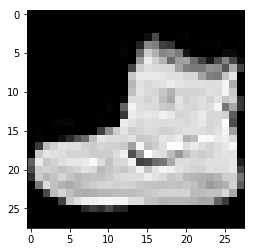

In [7]:
plt.imshow(image, cmap="gray")

In [8]:
batch = next(iter(train_loader))
print(len(batch))

2


In [9]:
images, labels = batch
print(images.shape,labels.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])


labels: tensor([0, 3, 3, 9, 2, 5, 0, 1, 5, 2])


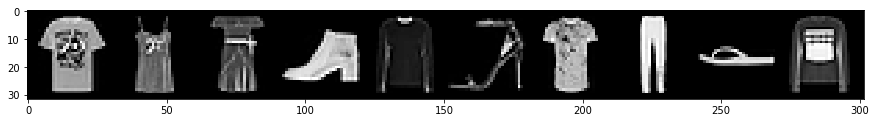

In [10]:
# To plot the images we can use toruch in-built fuction to make a nice grid
grid = torchvision.utils.make_grid(images[:10], nrow=10)

plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid, (1,2,0)))

print('labels:', labels[:10])

In [11]:
# Network
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features=12 * 4 * 4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)
        
    def forward(self, t):
        # implement the forward pass
        return t

In [13]:
network = Network()
print(network)

Network(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=192, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=10, bias=True)
)


In [14]:
# Access a single layer
print(network.conv1)

Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))


In [17]:
print(network.conv1.weight)
#One thing to notice about the weight tensor output is that it says parameter 
#containing at the top of the output. This is because this particular tensor is 
#a special tensor because its values or scalar components are learnable parameters of our network.
print(network.conv1.weight.shape)
# Number of output feature maps x number of input feature maps x kernel size x kernel size

Parameter containing:
tensor([[[[-0.0903,  0.0627, -0.1234, -0.0697,  0.1607],
          [ 0.0319, -0.1045, -0.1754,  0.0442, -0.0511],
          [ 0.0939, -0.0047, -0.1228,  0.0706,  0.0080],
          [ 0.0712, -0.1027, -0.0511, -0.1745,  0.1138],
          [-0.0744, -0.0451,  0.0029,  0.1582, -0.1181]]],


        [[[-0.0338,  0.1615,  0.0208,  0.1854, -0.1812],
          [ 0.0979, -0.0031, -0.1831,  0.1777,  0.1070],
          [-0.1801,  0.0080, -0.1313, -0.0287,  0.1926],
          [-0.1447, -0.0587,  0.1172, -0.1552, -0.0853],
          [ 0.1691,  0.1737,  0.1268, -0.1636, -0.1184]]],


        [[[-0.0407, -0.0687,  0.1652, -0.0677, -0.1475],
          [ 0.1238, -0.1952,  0.1919, -0.0887, -0.0208],
          [ 0.0735, -0.0272,  0.0315,  0.1914, -0.1946],
          [ 0.1111,  0.1103, -0.0123, -0.1506, -0.0065],
          [-0.0573, -0.1759,  0.1591,  0.1692, -0.1633]]],


        [[[-0.0768, -0.1088, -0.1301, -0.0415,  0.1600],
          [-0.1549, -0.0680,  0.1911, -0.1184, -0.1586

In [18]:
# Access the parameters
for param in network.parameters():
    print(param.shape)

torch.Size([6, 1, 5, 5])
torch.Size([6])
torch.Size([12, 6, 5, 5])
torch.Size([12])
torch.Size([120, 192])
torch.Size([120])
torch.Size([60, 120])
torch.Size([60])
torch.Size([10, 60])
torch.Size([10])


#### Definition of a Linear class (an example) taken directly from the PyTorch class
```python
def __init__(self, in_features, out_features, bias=True):
    super(Linear, self).__init__()
    self.in_features = in_features
    self.out_features = out_features
    self.weight = Parameter(torch.Tensor(out_features, in_features))
    if bias:
        self.bias = Parameter(torch.Tensor(out_features))
    else:
        self.register_parameter('bias', None)
    self.reset_parameters()
```